In [73]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [91]:
# class CustomDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         """
#         Args:
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.png'))]

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_name = self.image_files[idx]
#         image = Image.open(img_name).convert('RGB')  # Ensure image is RGB
#         if self.transform:
#             image = self.transform(image)
#         return image

# # Path to your dataset directory
# dir_images = 'data/dataset/images'
# dir_labels = 'data/dataset/labels'

# # Usage
# dataset_images = CustomDataset(dir_images, transform=transforms.ToTensor())
# dataset_dots = CustomDataset(dir_labels, transform=transforms.ToTensor())

# dataloaders = {
#     'images': DataLoader(dataset_images, shuffle=False, batch_size=20),
#     'labels': DataLoader(dataset_dots, shuffle=False, batch_size=20)
#   }



<class 'torch.utils.data.dataloader.DataLoader'>


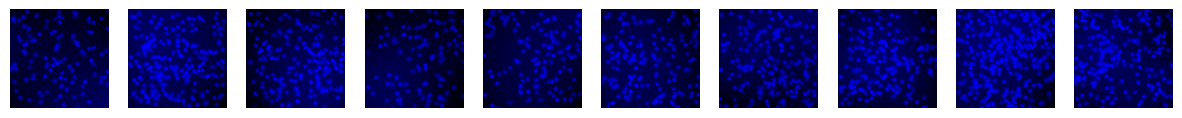

<class 'torch.utils.data.dataloader.DataLoader'>


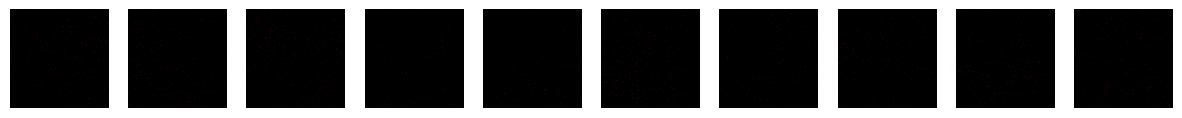

In [65]:

# # Display function to show images
# def show_images(dataloader, num_images=10):
#     # Get a batch of images
#     print(type(dataloader))
#     images = next(iter(dataloader))
    
#     # Create a grid of subplots
#     fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
    
#     # Plot each image in the batch
#     for i, img in enumerate(images):
#         if i >= num_images:
#             break
#         ax = axes[i] if num_images > 1 else axes
#         img = img.numpy().transpose((1, 2, 0))  # Convert from Torch tensor to numpy and correct the channel order
#         ax.imshow(img)
#         ax.axis('off')
#     plt.show()

# show_images(dataloaders['images'])
# show_images(dataloaders['labels'])

In [45]:
labels = next(iter(dataloaders['labels']))


tensor(198.)

In [113]:
labels = next(iter(dataloaders['labels']))
for i in range(len(labels)):
    print(int(labels[i].sum()))

198
208
238
112
126
254
132
168
215
197
98
100
78
192
244
120
96
115
155
230


In [97]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, data_folder, label_folder):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.data_folder = data_folder
        self.label_folder = label_folder
        self.data_dir = os.path.join(root_dir, data_folder)
        self.label_dir = os.path.join(root_dir, label_folder)
        self.transform = transforms.ToTensor()
        self.image_files = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')  # Ensure image is RGB
        image = self.transform(image)
        
        label_name = img_name.replace('cell', 'dots').replace(self.data_folder, self.label_folder)
        label_image = Image.open(label_name).convert('RGB')  # Ensure image is RGB
        label_image = self.transform(label_image)
        
        label = label_image.sum()
        return image, label


dir = 'data/dataset'
dataset = CustomDataset(dir, 'images', 'labels')
dataloader = DataLoader(dataset, batch_size=20, shuffle=False)

tensor([115., 235., 193., 116., 136., 168., 190., 192., 306., 223.,  81., 278.,
        255., 155.,  96., 134.,  89.,  92., 250., 231.])


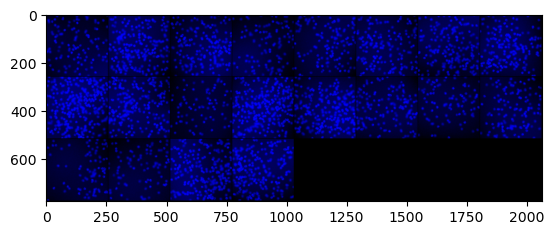

In [98]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch of training data
images, labels = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

print(labels)
imshow(out)

In [72]:
images

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0118, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0118, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0078,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0039, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.1333, 0.1216, 0.1176,  ..., 0.3098, 0.2902, 0.2784],
          [0.1255, 0.1294, 0.1137,  ..., 0.3608, 0.3373, 0.3216],
          [0.1020, 0.1020, 0.0941,  ..., 0

In [109]:
class DotCounterNet(nn.Module):
    def __init__(self):
        super(DotCounterNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.dropout = nn.Dropout(0.5)
        # Adjust the following line to match your exact input size after convolution and pooling layers
        self.fc1 = nn.Linear(32 * 29 * 29, 300)  # You might need to recalculate this size based on your input image dimensions
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 1)  # Change from 9 to 1 for regression

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)  # No activation function like softmax or sigmoid
        return x

net = DotCounterNet()


In [110]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [111]:
model = net.to(device)

In [112]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 60
# Example training loop (simplified)
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        inputs=inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))  # Ensure targets are correctly shaped
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 6982.52685546875
Epoch 2, Loss: 2633.325927734375
Epoch 3, Loss: 1184.6976318359375
Epoch 4, Loss: 1013.0828247070312
Epoch 5, Loss: 792.127685546875
Epoch 6, Loss: 800.2044677734375
Epoch 7, Loss: 689.1154174804688
Epoch 8, Loss: 491.49102783203125
Epoch 9, Loss: 353.66632080078125
Epoch 10, Loss: 211.0109100341797
Epoch 11, Loss: 76.35665893554688
Epoch 12, Loss: 133.2220001220703
Epoch 13, Loss: 39.30082321166992
Epoch 14, Loss: 60.25347900390625
Epoch 15, Loss: 37.370784759521484
Epoch 16, Loss: 38.127742767333984
Epoch 17, Loss: 33.03753662109375
Epoch 18, Loss: 28.548995971679688
Epoch 19, Loss: 25.98894691467285
Epoch 20, Loss: 21.741622924804688
Epoch 21, Loss: 16.288206100463867
Epoch 22, Loss: 11.336413383483887
Epoch 23, Loss: 10.699670791625977
Epoch 24, Loss: 23.589954376220703
Epoch 25, Loss: 58.5132942199707
Epoch 26, Loss: 8.939175605773926
Epoch 27, Loss: 75.23043060302734
Epoch 28, Loss: 9.455100059509277
Epoch 29, Loss: 8.71418571472168
Epoch 30, Loss: